In [22]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
# from impedance.models.circuits import CustomCircuit
from matplotlib.ticker import MultipleLocator
from scipy.optimize import minimize
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from models import *

In [2]:
for i in [1,2,3]:
    print(1-(i/4)**(1/3))

0.3700394750525634
0.2062994740159002
0.09143970358393017


## Define the arbitary tortuosity model

In [23]:
@element(num_params=7,units=["","","","","","",""],overwrite=True)
def arbitRCPE(p,f):
    Q, alpha, R1, R2, R3,R4,R5 = p[0], p[1], p[2], p[3], p[4], p[5],p[6]
    x1 = np.array([0,0.091,0.206,0.37,1])
    # y = np.array([500,400,300,100])
    y1 = np.array([R1,R2,R3,R4,R5])
    def R(xpoint):
        # return a/(1+b*x)
        # return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
        return np.interp(xpoint,x1,y1)
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*R(x),y[3]*R(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
 
    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*np.cos(alpha*np.pi/2)
        lmdsin=w**alpha*Q*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1
    return Z_list

(0.0, 2000.0)

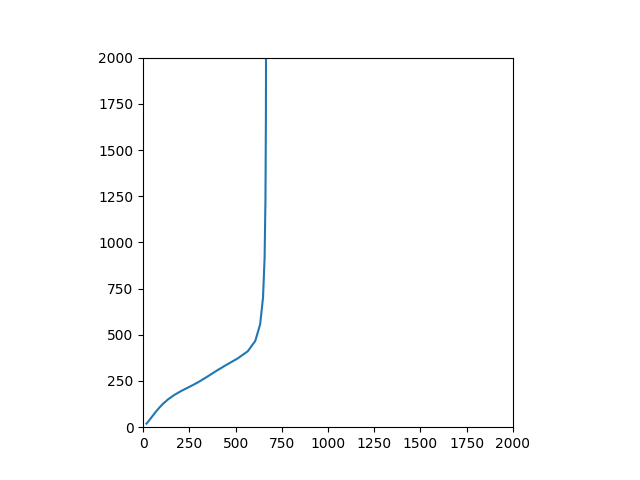

In [24]:
Q,alpha,R1,R2,R3,R4,R5=1e-4,1,1000,800,700,600,400

R6,Q1=100,1e-5

# c=CustomCircuit(initial_guess=[Q,alpha,R1,R2,R3,R4,R5],circuit="arbitRCPE")
c=CustomCircuit(initial_guess=[R1,R1*Q,R5*Q,alpha,R6,Q1],circuit="TLMlinnew0-p(R0,C)")

freq=np.logspace(-3,4,50)
z_data=c.predict(freq)

fig, ax=plt.subplots()
ax.plot(np.real(z_data),-np.imag(z_data))
ax.set_aspect("equal")
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)

In [25]:


c_to_fit=CustomCircuit(initial_guess=[Q*1.5,alpha,R1*1.5,R2*1.6,R3*1.8,R4*1.9,R5*1.7],circuit="arbitRCPE")

# c_to_fit=CustomCircuit(initial_guess=[R1,1.2*R1*Q,1.5*R5*Q,alpha],circuit="TLMlinnew")

wt="mod"
wt_mod=np.hstack((np.abs(z_data),np.abs(z_data)))


c_to_fit.fit(impedance=z_data,frequencies=freq,gtol=1e-10,sigma=wt_mod)
# c_to_fit.fit(impedance=z_data,frequencies=freq,gtol=1e-10)
z_fit=c_to_fit.predict(freq)
print(c_to_fit)


Circuit string: arbitRCPE
Fit: True

Initial guesses:
  arbitRCPE_0 = 1.50e-04 []
  arbitRCPE_1 = 1.00e+00 []
  arbitRCPE_2 = 1.50e+03 []
  arbitRCPE_3 = 1.28e+03 []
  arbitRCPE_4 = 1.26e+03 []
  arbitRCPE_5 = 1.14e+03 []
  arbitRCPE_6 = 6.80e+02 []

Fit parameters:
  arbitRCPE_0 = 9.93e-05  (+/- 4.24e-07) []
  arbitRCPE_1 = 9.97e-01  (+/- 1.44e-03) []
  arbitRCPE_2 = 1.06e+03  (+/- 2.92e+01) []
  arbitRCPE_3 = 2.23e+03  (+/- 4.03e+01) []
  arbitRCPE_4 = 6.24e-06  (+/- 4.02e+00) []
  arbitRCPE_5 = 7.43e+02  (+/- 1.10e+02) []
  arbitRCPE_6 = 1.09e+03  (+/- 5.13e+02) []



In [6]:
# from scipy.interpolate import Akima1DInterpolator
# # import matplotlib.pyplot as plt
# x = np.linspace(1, 7, 7)
# y = np.array([-1, -1, -1, 0, 1, 1, 1])
# xs = np.linspace(min(x), max(x), num=100)
# y_akima = Akima1DInterpolator(x, y)(xs)
# # y_makima = Akima1DInterpolator(x, y)(xs)
# fig, ax = plt.subplots()
# ax.plot(x, y, "o", label="data")
# ax.plot(xs, y_akima, label="akima")
# # ax.plot(xs, y_makima, label="makima")
# ax.legend()
# fig.show()

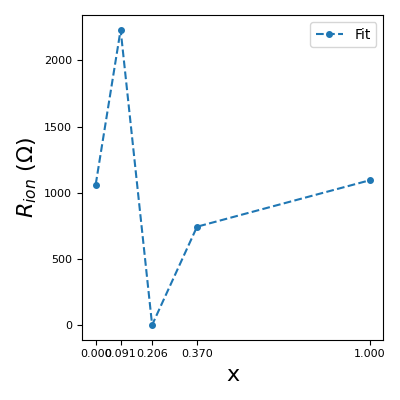

In [33]:
R1_fit=c_to_fit.parameters_[2]
R2_fit=c_to_fit.parameters_[3]
R3_fit=c_to_fit.parameters_[4]
R4_fit=c_to_fit.parameters_[5]
R5_fit=c_to_fit.parameters_[6]

# R1_fit=c_to_fit.parameters_[0]
# Q_fit=c_to_fit.parameters_[1]/R1_fit
# R2_fit=c_to_fit.parameters_[2]/Q_fit

fig, ax=plt.subplots()
fig.set_size_inches(4,4)
ax.set_xlabel("x",fontsize=16)
ax.set_ylabel("$R_{ion}$ $(\Omega)$",fontsize=16)
# ax.plot([0,1],[R1,R5],label="Data")
# ax.plot([0,0.091,0.206,0.37,1],[1420,1750,0.38,0.05,0.16],label="Fit 1")
# ax.plot([0,0.091,0.206,0.37,1],[R1_fit,R2_fit,R3_fit,R4_fit,R5_fit],label="Fit 1")
# ax.plot([0,0.091,0.206,0.37,1],[R1_fit,R2_fit,R3_fit,R4_fit,R5_fit],label="Fit")
ax.plot([0,0.091,0.206,0.37,1],[R1_fit,R2_fit,R3_fit,R4_fit,R5_fit],linestyle="--",marker="o",ms=4,label="Fit")
# ax.plot([0,0],[0,R1],color="black",linewidth=0.5)
# ax.plot([0.0914,0.0914],[0,R2],color="black",linewidth=0.5)
# ax.plot([0.2063,0.2063],[0,R3],color="black",linewidth=0.5)
# ax.plot([0.37,0.37],[0,R4],color="black",linewidth=0.5)
# ax.plot([1,1],[0,R5],color="black",linewidth=0.5)
# ax.set_ymargin(0)
# ax.set_ylim(0,1100)
ax.legend()
ax.set_xticks([0,0.091,0.206,0.37,1])
# ax.set_xticklabels(["$x_1=0$","$x_2=0.091$","$x_3=0.206$","$x_4=0.37$","$x_5=1$"])
ax.tick_params(labelsize=8)
# ax.grid(linewidth=0.5,alpha=0.5)
fig.tight_layout()
fig.savefig("linOnArbit.png",dpi=700)

(0.0, 10000.0)

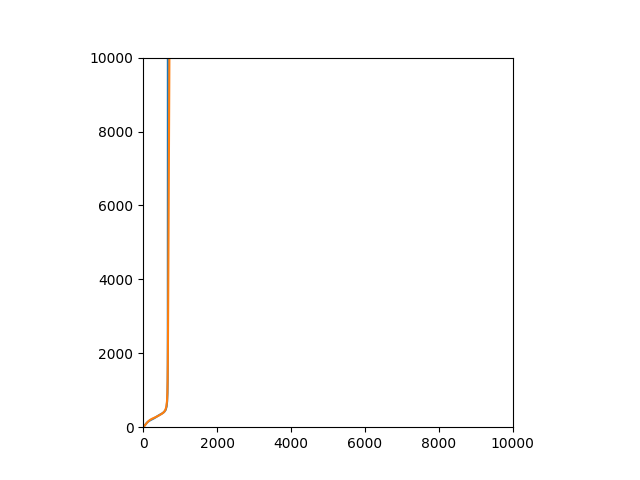

In [8]:
fig2,ax2=plt.subplots()
ax2.plot(np.real(z_data),-np.imag(z_data))
ax2.plot(np.real(z_fit),-np.imag(z_fit))
ax2.set_aspect("equal")
ax2.set_ylim(0,10000)
ax2.set_xlim(0,10000)

In [9]:
#if I have an atom and I split it into two
#What i am going to tell you now Kamlu, is not something you will want to listen, or something you may have ever seen, but still listen to me, as anyways you dont have any urgent work to do now, have you ever opened a battery?, with a stone, then just tiks tiks and tiks...., what was inside that? something black, a paste right? Now if I tell you that I can make such battery from scratch, do you care to learn. actually this kind of battery in remote is non-rechargable, I even know how to make a rechargable battery. but will you want to learn that, evem if you magically have the raw material needed for it , lying in your garage right now, Even If you make it, no one will buy it, why?? bcoz anyone can buy them from the shops nowdays just for rs.10, then what? even if you will be able to make one, it has to go through checks, that you will never have the patience to go through, but even if you will be able to produce it for rs. 20 per one 5000mAh cell, then still,

In [10]:
#Academic researchers are a reserved force of the soceity, (But what is soceity)..
#So india is a society as a country, one step down, is himachal a society?, does society mean that people constituting it know that they are interdepentand on other members of the society for their life(for survival, ofcourse, for defence from outsite forces which will want to hurt us(so that they can win resources(what is it?) to better(what does better mean?) their society), for healthcare, for education (lol we have youtube, a gift from the American society, internet also is a gift from the american society),If the border of the countries were closed with no exchange of xyz, then could we had xyz, or we could had), can everyone in the society has the time and whatevr else fk to look at this broad view of society they are dependant on. Or I have raised to the level that I dont care about certain (what are they?) things, that are still important to 

In [11]:
#To create a family (group of individuals biologically related), where each other are avaible in close proximity, plus they are contributing to the local society and also the national society. For example, I am getting that of Jwala dadus family, when sonu was a boy himself, then his father was contributing as being a wheel operator in the local society, at that time, he entered a market where jobs were just newly created and he grabbed, and then somehow the fate of his whole family to be in future was decided(maybe 50% contribution)., I have jumped to the third thought of the day(not day but just 20 minutes),
#a small word creats a link to the whole chain of memories. 

In [12]:
#can I live in such place for whole life, can I not earn a lot of money and then just leave the bandhan to go to work for my whole life time, I just keep getting some money (income) (somehow), and I just roam around and do nothing(what does it mean to be free). Have I ever felt it, like I am in a ...
# when I imagine being free I think of the land I own, why is there an urge to make something (tech and stuff) there., who is free, is that cat free, Its life about looking for food, indulging in on the spot activities.

In [13]:
#Why mfr has low value friends, why are they low value, they dont seem charismatic, Why is it bad, because it has not authority over anything, and then end up as 
#As a child the parents are the ideal world to the kids, and all other beings are deviations from that ideal behaviour, why I am gettting the thought of it(this) being read by 

In [14]:
#Electrical charaterization, force the word I just saw, I am getting your thoughts again and again,..,

## Plot that profile here

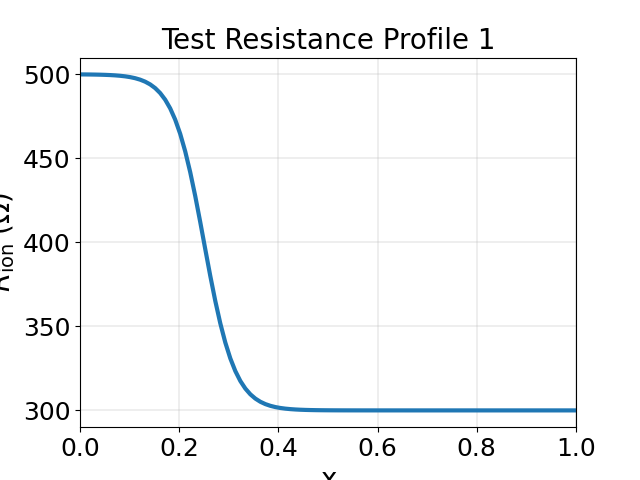

In [15]:
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
axx.plot(x,R(x),linewidth=3)
axx.set_xlabel("x",fontsize=20)
axx.set_ylabel("$R_{\mathrm{ion}}$$\;$($\Omega$)",fontsize=20)
axx.grid(linewidth=0.3)
axx.set_title("Test Resistance Profile 1",fontsize=20)
axx.set_xlim(0,1)
axx.tick_params(labelsize=18)
# ax.set_title(title)
fig1.savefig("figs/prof1.png",dpi=500,bbox_inches="tight")
# axx2=axx.twinx()
# axx2.set_ylabel("R1")

# axx.plot([0,0.2063,0.2063,1],[873,873,387,387])

## Find Out the dip angle and the apparent R_ion

In [16]:
Q=6e-4
alpha=0.9
a=4
b=4
param=[Q,alpha,a,b]
freq_range=np.logspace(-2,3,100)
c=CustomCircuit(initial_guess=param,circuit="arbitRCPE")
z=c.predict(frequencies=freq_range)
#found the dip angle
dip_angle=alpha*45-np.min(-np.angle(z,deg=True))

#found the Rion by finding the intercept

datax=np.real(z[:int(len(z)*0.3)])
datay=np.imag(z[:int(len(z)*0.3)])

ff,ax=plt.subplots()

ax.plot(datax,-datay,label="Exp")
ax.set_aspect("equal")

#actual fitting of a straight line
cp=np.polyfit(datax,-datay,1)
cp[0] 
cp[1] 
print(f"{cp[0]}{cp[1]}")

def y(x,cp):
    return cp[0]*x+cp[1]

ax.plot(datax,y(datax,cp),label="Fit Line")
R_ion_app=(3/2)*(-cp[1]/cp[0])

print(f"intercept: {-cp[1]/cp[0]}")
print(f"R_ion_app: {R_ion_app}")

ax.legend()

ValueError: The number of initial guesses (4) + the number of constants (0) must be equal to the circuit length (7)

In [ ]:
R1uni,Quni,alphauni=412.5, 6e-4, 0.8
c_uni=CustomCircuit(initial_guess=[R1uni,Quni,alphauni],circuit="TLMuni")
freq_range=np.logspace(-2,3,100)
z_uni=c_uni.predict(frequencies=freq_range)
#found the dip angle
dip_angle_uni=alphauni*45-np.min(-np.angle(z_uni,deg=True))
dip_angle_uni

0.3754053863537834

In [17]:
import json
file_path = "theta_data_all.json"

with open(file_path, "r") as file:
    json_data = file.read()

theta_list=json.loads(json_data)

# 1.5851811596605216 dip at 1
# 0.8214241785638094 dip at 0.9
# 0.3754053863537834 dip at 0.8


In [18]:
def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

#the ratio range for which the theta data is generated
ratio_range=np.linspace(1.2,10,50)

for pf,idx in zip(["Two-step","Linear","Inverse Linear"],[0,1,2]):
    if(pf=="Two-step"):
        # theta_dip_two=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R1_by_R2_two=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R2_two=2*R_ion_app/(1+R1_by_R2_two)
        R1_two=R2_two*R1_by_R2_two
    elif(pf=="Linear"):
        R1_by_R2_lin=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        R2_lin=4*R_ion_app/(1+3*R1_by_R2_lin)
        R1_lin=R2_lin*R1_by_R2_lin
    else:
        R1_by_R2_ilin=ratio_range[find_index_of_nearest(theta_list[idx][1],dip_angle)]
        # R2_ilin=4*R_ion_app*(R1_by_R2_ilin**3-3*R1_by_R2_ilin**2+3*R1_by_R2_ilin-1)/(9*R1_by_R2_ilin*(2*np.log(R1_by_R2_ilin)*R1_by_R2_ilin**2-3*R1_by_R2_ilin**2+4*R1_by_R2_ilin-1))
        # R1_ilin=R2_ilin*R1_by_R2_ilin

        R2_ilin=2*R_ion_app*(R1_by_R2_ilin**3-3*R1_by_R2_ilin**2+3*R1_by_R2_ilin-1)/(3*R1_by_R2_ilin*(2*np.log(R1_by_R2_ilin)*R1_by_R2_ilin**2-3*R1_by_R2_ilin**2+4*R1_by_R2_ilin-1))
        R1_ilin=R2_ilin*R1_by_R2_ilin

R1_by_R2_two
# R1_by_R2_lin
# R2_lin
R1_ilin
# R2_ilin

# theta_dip_ll=[]

NameError: name 'dip_angle' is not defined

## Show the point of dip angle for lin and ilin and two on the plots

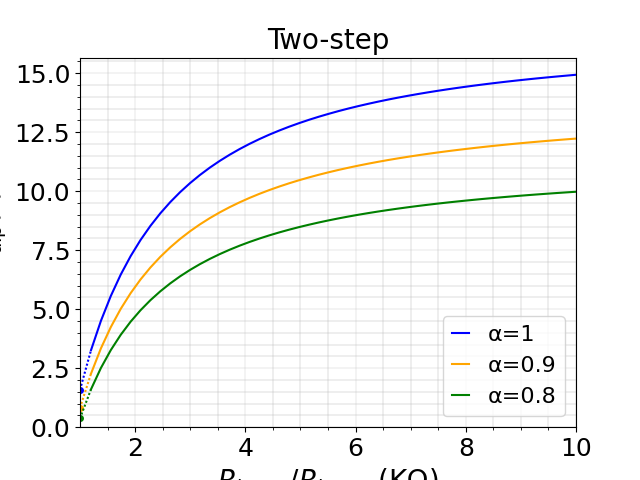

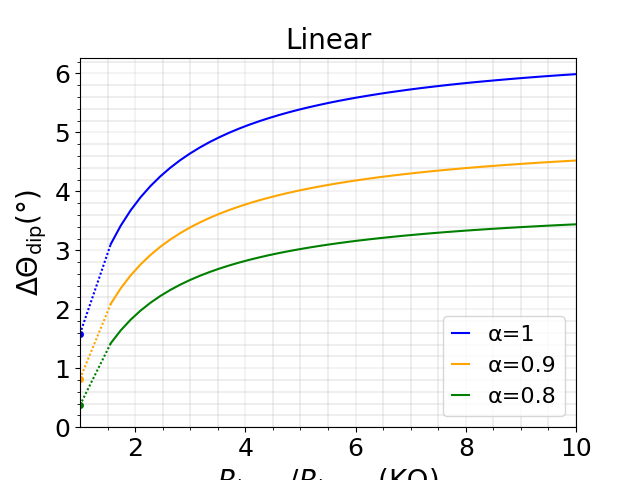

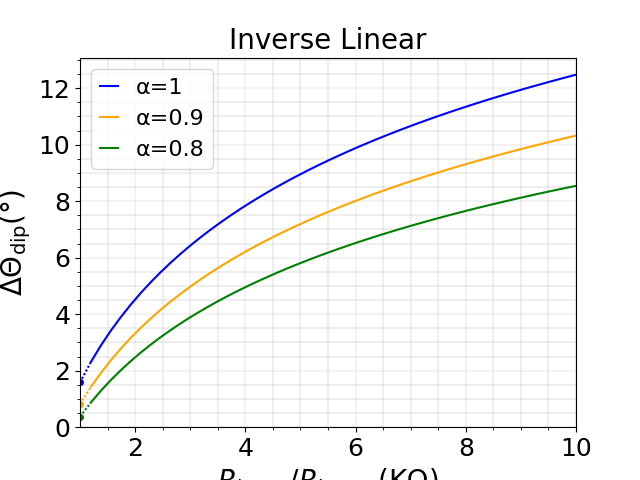

In [21]:
fig,axtwo=plt.subplots()
fig1,axlin=plt.subplots()
fig2,axilin=plt.subplots()
x=ratio_range

crap_till_lin=2

for idx1,ax,fg,title in zip([0,1,2],(axtwo,axlin,axilin),(fig,fig1,fig2),("Two-step","Linear","Inverse Linear")):
    for idx2,a,dip_at_1,clr in zip([0,1,2],[1,0.9,0.8],[1.5851811596605216,0.8214241785638094,0.3754053863537834],["blue","orange","green"]):
        if(idx1==1):
            ax.plot(1,dip_at_1,"o",ms=4,color=clr)
            ax.plot([1,ratio_range[crap_till_lin:][0]],[dip_at_1,theta_list[idx1][idx2][crap_till_lin:][0]],linestyle="--",dashes=[1,1],color=clr)
            # ax.plot(np.hstack(([1],ratio_range[crap_till_lin:])),np.hstack((dip_at_1,theta_list[idx1][idx2][crap_till_lin:])),label=f"α={a}",color=clr)
            ax.plot(ratio_range[crap_till_lin:],theta_list[idx1][idx2][crap_till_lin:],label=f"α={a}",color=clr)
            
        else:
            ax.plot(1,dip_at_1,"o",ms=4,color=clr)
            ax.plot([1,ratio_range[0]],[dip_at_1,theta_list[idx1][idx2][0]],linestyle="--",dashes=[1,1],color=clr)
            # ax.plot(np.hstack(([1],ratio_range)),np.hstack((dip_at_1,theta_list[idx1][idx2])),label=f"α={a}",color=clr)
            ax.plot(ratio_range,theta_list[idx1][idx2],label=f"α={a}",color=clr)
            # ax.plot(ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)],dip_angle,"*")
        # ax.plot(1,dip_at_1,"o")
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.yaxis.set_minor_locator(MultipleLocator(0.5))
        ax.legend()
        ax.grid(which="both",linewidth=0.3)
        ax.minorticks_on()
        ax.set_xlabel("$R_{\mathrm{ion},1}$/$R_{\mathrm{ion},2}\;$(K$\Omega$)",fontsize=20)
        ax.set_ylabel("$\Delta \Theta_{\mathrm{dip}} (\degree)$",fontsize=20)
        ax.set_title(title,fontsize=20)
        # ax.set_xlim(0,10)
        # ax.set_xlim(0,10)
    # ax.plot(ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)],dip_angle,"*",color="red")
    # ax.plot([ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)],ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)]],[0,dip_angle],"--",color="black")
    # ax.plot([0,ratio_range[find_index_of_nearest(theta_list[idx1][1],dip_angle)]],[dip_angle,dip_angle],"--",color="black")
    ax.set_xlim(1,10)
    ax.tick_params(labelsize=18)
    # ax.set_xlabel("x",fontsize=20)
    ax.legend(fontsize=16,handlelength=0.8)
    ax.grid(linewidth=0.2)
    # ax.plot(,"--",color)
    # ax.set_ymargin(1)
    ax.set_ylim(0)
    fg.savefig(f"figs/prof1_dipvsR1R2_{title}.png",dpi=500,bbox_inches="tight")

4.8

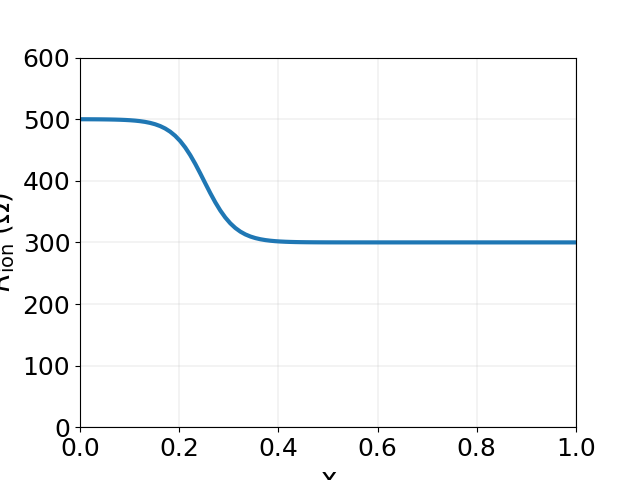

In [ ]:
delta=0.2063
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
#plot the arbitray profile
axx.plot(x,R(x),label="Test profile 1",linewidth=3)
# axx.plot(x,R(x))
#plot the fitted profiles
# axx.plot([0,delta,delta,1],[R1_two,R1_two,R2_two,R2_two],label="Two-step")
# axx.set_title("Test profile 1")
# axx.set_title("Inverse-Linear resistance profile")
# axx.set_title("Linear resistance profile")
# axx.plot([0,1],[R1_lin,R2_lin],label="Linear")

def R_ilin(x):
    return 1/(1/R1_ilin+(1/R2_ilin-1/R1_ilin)*x)
# axx.plot(x,R_ilin(x),label="Inverse Linear")

# axx.set_xlim(0,)
axx.set_ylim(0,600)
axx.set_xlim(0,1)
axx.tick_params(labelsize=18)
axx.set_xlabel("x",fontsize=20)
# axx.set_title("Fitted Elementary Profiles")
# axx.set_ylabel("$R_{\mathrm{ion},1}$ or $R_{\mathrm{ion},2}\;$($\Omega$)",fontsize=20)
axx.set_ylabel("$R_{\mathrm{ion}}$$\;$($\Omega$)",fontsize=20)
# axx.legend(fontsize=16,handlelength=0.8)
axx.grid(linewidth=0.2)

# axx.set_title("Fittde")
# fig1.savefig("fitted_prof1.png",dpi=500)
fig1.savefig("figs/dm_prof1.png",dpi=500,bbox_inches="tight")
fig1.get_figwidth()
fig1.get_figheight()

4.8

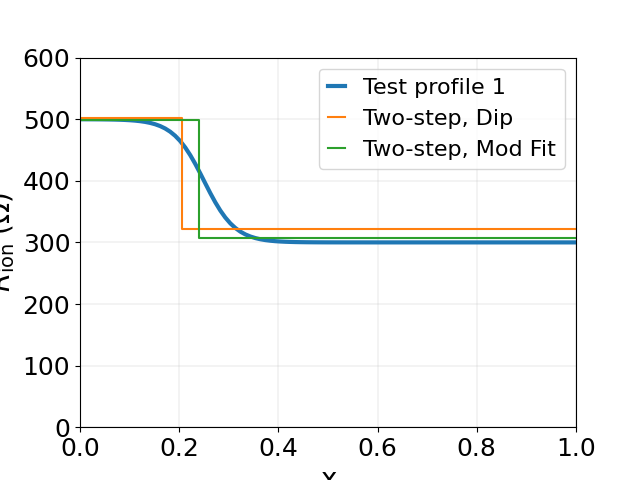

In [ ]:
#here I plot the error minimization fitted profiles along with the dip angle fitted profiles
# import json
file_path = f"two_fit_prof1.json"
with open(file_path, "r") as file:
    json_data = file.read()
fit_params_two=json.loads(json_data)

# R1_two_fit=fit_params_two[R1"]


delta=0.2063
fig1, axx= plt.subplots()
x=np.linspace(0,1,100)
a=4
b=4
def R(x):
    return 100*(a*np.tanh(b**2-a*x)+np.tanh(a-b**2*x))
#plot the arbitray profile
axx.plot(x,R(x),label="Test profile 1",linewidth=3)
# axx.plot(x,R(x))
#plot the fitted profiles
axx.plot([0,delta,delta,1],[R1_two,R1_two,R2_two,R2_two],label="Two-step, Dip")
axx.plot([0,fit_params_two["delta"],fit_params_two["delta"],1],[fit_params_two["R1"],fit_params_two["R1"],fit_params_two["R2"],fit_params_two["R2"]],label="Two-step, Mod Fit")
# axx.plot([0,delta,delta,1],[R1_two,R1_two,R2_two,R2_two],label="Two-step")
# axx.set_title("Test profile 1")
# axx.set_title("Inverse-Linear resistance profile")

file_path = f"lin_fit_prof1.json"
with open(file_path, "r") as file:
    json_data = file.read()
fit_params_lin=json.loads(json_data)
# axx.set_title("Linear resistance profile")
# axx.plot([0,1],[R1_lin,R2_lin],label="Linear, Dip")
# axx.plot([0,1],[fit_params_lin["R1"],fit_params_lin["R2"]],label="Linear, Mod Fit")

def R_ilin(x):
    return 1/(1/R1_ilin+(1/R2_ilin-1/R1_ilin)*x)



file_path = f"ilin_fit_prof1.json"
with open(file_path, "r") as file:
    json_data = file.read()
fit_params_ilin=json.loads(json_data)

def R_ilin_fit(x):
    return 1/(1/fit_params_ilin["R1"]+(1/fit_params_ilin["R2"]-1/fit_params_ilin["R1"])*x)
# axx.set_title("InLinear resistance profile")
# axx.plot([0,1],[R1_lin,R2_lin],label="Linear, Dip")
# axx.plot([0,1],[fit_params_lin["R1"],fit_params_lin["R2"]],label="Linear, Mod Fit")
# axx.plot(x,R_ilin(x),label="Inverse Linear, Dip")
# axx.plot(x,R_ilin_fit(x),label="Inverse Linear, Mod Fit")

# axx.set_xlim(0,)
axx.set_ylim(0,600)
axx.set_xlim(0,1)
axx.tick_params(labelsize=18)
axx.set_xlabel("x",fontsize=20)
# axx.set_title("Fitted Elementary Profiles")
# axx.set_ylabel("$R_{\mathrm{ion},1}$ or $R_{\mathrm{ion},2}\;$($\Omega$)",fontsize=20)
axx.set_ylabel("$R_{\mathrm{ion}}$$\;$($\Omega$)",fontsize=20)
axx.legend(fontsize=16,handlelength=0.8)
axx.grid(linewidth=0.2)

# axx.set_title("Fittde")
# fig1.savefig("fitted_prof1.png",dpi=500)
fig1.savefig("figs/modfit_two_lin_prof1.png",dpi=500,bbox_inches="tight")
fig1.get_figwidth()
fig1.get_figheight()

In [ ]:
# print(fit_params)
# fit_params["delta"]

## Show the fitted profiles ( two, lin and ilin)

In [ ]:
Q=6e-4
alpha=0.9
delta=0.2063
a=4
b=4
param=[Q,alpha,a,b]
c_arbi=CustomCircuit(initial_guess=param,circuit="arbitRCPE")
# c=CustomCircuit(initial_guess=[6e-4,0.9,4,4],circuit="arbitRCPE")
z_arbi=c_arbi.predict(frequencies=np.logspace(-2,3,100))

c_two=CustomCircuit(initial_guess=[R1_two,R1_two*Q,R2_two*Q,delta,alpha],circuit="TLMtwo")
z_two=c_two.predict(frequencies=freq_range)

c_lin=CustomCircuit(initial_guess=[R1_lin,R1_lin*Q,R2_lin*Q,alpha],circuit="TLMlinnew")
z_lin=c_lin.predict(frequencies=freq_range)

print(R1_ilin)
c_ilin=CustomCircuit(initial_guess=[R1_ilin,R1_ilin*Q,R2_ilin*Q,alpha],circuit="TLMilinnew")
mp.dps=100
z_ilin=c_ilin.predict(frequencies=freq_range)
mp.dps=30
# c_ilin=CustomCircuit(initial_guess=[R1_ilin,R1_ilin*Q,R2_ilin*Q,alpha],circuit="TLMilinnew")
# z_ilin=c_ilin.predict(frequencies=np.logspace(-2,3,100))



# print(0.9*45-np.min(-np.angle(z,deg=True)))

541.43145373158


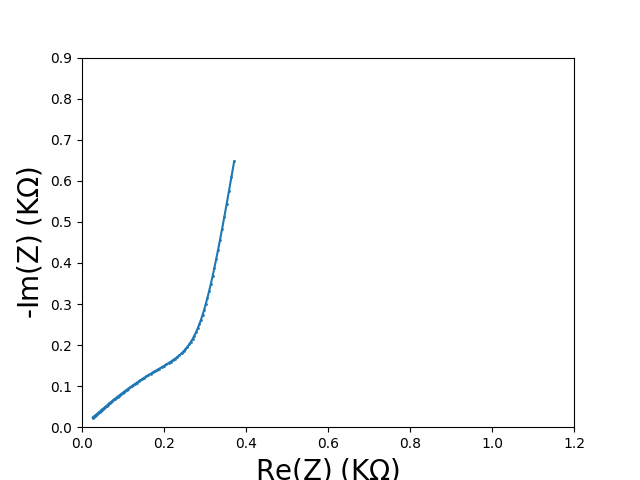

In [ ]:
ctwofit=CustomCircuit(initial_guess=[fit_params_two["R1"],fit_params_two["Q"]*fit_params_two["R1"],fit_params_two["Q"]*fit_params_two["R2"],fit_params_two["delta"],fit_params_two["alpha"]],circuit="TLMtwo")
ztwofit=ctwofit.predict(frequencies=np.logspace(0,3,100))

fig, ax=plt.subplots()
# ax.plot(np.real(z_arbi)/1000,-np.imag(z_arbi)/1000,label="Test profile 1",marker=".",linewidth=3,ms=6)
# ax.plot(np.real(z_arbi)/1000,-np.imag(z_arbi)/1000,marker=".",ms=2)
# ax.plot([0,0],[0.35,0.35])
# ax.plot(np.real(z_two)/1000,-np.imag(z_two)/1000,label="Two-step, Dip",marker=".",ms=2)
ax.plot(np.real(ztwofit)/1000,-np.imag(ztwofit)/1000,label="Two-step, Mod Fit",marker=".",ms=2)
# ax.plot(np.real(z_lin)/1000,-np.imag(z_lin)/1000,label="Linear",marker=".",ms=2)
# ax.plot(np.real(z_ilin)/1000,-np.imag(z_ilin)/1000,label="Inverse Linear",marker=".",ms=2)
# ax.plot(np.real(z_lin)/1000,-np.imag(z_lin)/1000)
ax.set_aspect("equal")
ax.set_xlabel("Re(Z)$\;($K$\Omega$)",fontsize=20)
ax.set_ylabel("-Im(Z)$\;($K$\Omega$)",fontsize=20)
# ax.set_title("Nyquist Plot")
ax.set_xlim(0,1.2)
ax.set_ylim(0,0.9)

# ax.legend(fontsize=16,handlelength=0.8)
# fig.savefig("figs/nyq_demo.png",dpi=500)
# fig.savefig("figs/nyq_prof1_two.png",dpi=500)
fig.savefig("figs/nyq_for_non_uniq.png",dpi=500,bbox_inches="tight")
# fig.savefig("nyqfulltwo_demo.png",dpi=500)
# ax.legend()
# ax.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax.grid(True)


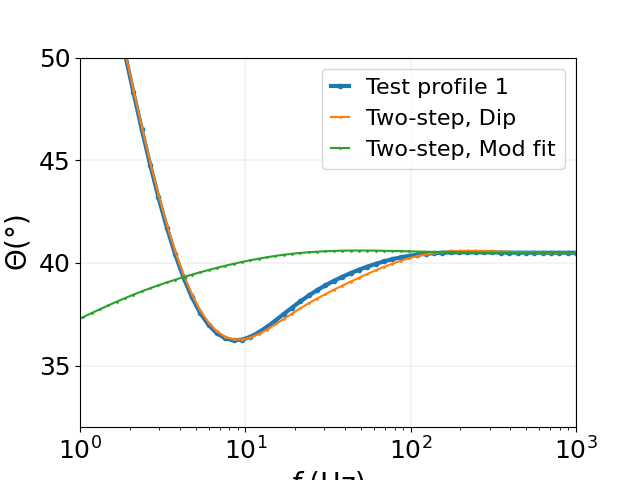

In [ ]:
fig2, ax2=plt.subplots()
ax2.plot(freq_range,-np.angle(z_arbi,deg=True),marker=".",label="Test profile 1",ms=6,linewidth=3)
# ax2.plot(freq_range,-np.angle(z_arbi,deg=True),marker=".",ms=2)

# ax2.plot(freq_range[int(len(freq_range)/2):len(freq_range)],np.full(int(len(freq_range)/2),-np.angle(z_arbi[len(z_arbi)-1],deg=True)),linestyle="--",color="black",label="Arbitrary")

# np.full(int(len(freq_range)/2),np.full(len(freq_range)-np.min(-np.angle(z,deg=True))))

# ax2.plot(freq_range[int(len(freq_range)/2):len(freq_range)],np.full(int(len(freq_range)/2),np.min(-np.angle(z,deg=True))),linestyle="--",color="black",label="Arbitrary")

ax2.plot(np.logspace(-2,3,100),-np.angle(z_two,deg=True),marker=".",label="Two-step, Dip",ms=2)
ax2.plot(np.logspace(-2,3,100),-np.angle(ztwofit,deg=True),marker=".",label="Two-step, Mod fit",ms=2)
# ax2.plot(np.logspace(-2,3,100),-np.angle(z_lin,deg=True),marker=".",label="Linear",ms=2)
# ax2.plot(np.logspace(-2,3,100),-np.angle(z_ilin,deg=True),marker=".",label="Inverse Linear",ms=2)
# ax2.legend()
# axx.yaxis.set_minor_locator(MultipleLocator(0.5))
ax2.set_ylabel("$\Theta (\degree)$",fontsize=20)
ax2.set_xlabel("$f$ (Hz)",fontsize=20)
ax2.set_xscale("log")
ax2.set_ylim(32,50)
ax2.set_xlim(1,1e3)
ax2.grid(linewidth=0.2)
# ax2.set_title("Phase Angle Plot")
ax2.tick_params(labelsize=18)
ax2.legend(fontsize=16,handlelength=0.8)
# ax2.set_xlabel("x",fontsize=20)
# ax2.set_xmargin(1)
# fig2.savefig("figs/bode_prof1_two.png",dpi=500)
fig2.savefig("figs/phase_mod_fit_two_prof1.png",dpi=500,bbox_inches="tight")
# fig2.savefig("bodetwo_demo.png",dpi=500)
# ax2.grid(True)

In [ ]:
# print(dip_angle)
# print(R1_by_R2_two)
# print(R1_by_R2_lin)
# print(R1_by_R2_ilin)

print(R1_ilin)
print(R2_ilin)

print(R_ion_app)

print(dip_angle)

541.43145373158
220.35001023959646
412.4983749776999
4.268797175965155
